## We want to create a diversified Portfolio, model a hypothetical catastrophic event through a single day stock price drop of 10%(all stocks), and then compare it to the calculated 1-day VaR and CVaR. At the end we backtest by comparing to historical data for COVID crash

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
import yfinance as yf
import time
tickers = ['AAPL','MSFT', 'GOOG', 'NVDA', 'AMZN']

start_date = '2020-01-01' # Covid crash
end_date = '2024-06-01'

adj_close_data={}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay just in case to prevent the server from being overloaded with requests

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())

                                AAPL        MSFT       GOOG      NVDA  \
Date                                                                    
2020-01-02 00:00:00-05:00  72.620842  153.042267  67.964508  5.971746   
2020-01-03 00:00:00-05:00  71.914810  151.136642  67.630981  5.876162   
2020-01-06 00:00:00-05:00  72.487846  151.527313  69.298584  5.900805   
2020-01-07 00:00:00-05:00  72.146973  150.145721  69.255333  5.972245   
2020-01-08 00:00:00-05:00  73.307510  152.537308  69.801102  5.983446   

                                AMZN  
Date                                  
2020-01-02 00:00:00-05:00  94.900497  
2020-01-03 00:00:00-05:00  93.748497  
2020-01-06 00:00:00-05:00  95.143997  
2020-01-07 00:00:00-05:00  95.343002  
2020-01-08 00:00:00-05:00  94.598503  


In [3]:
returns=data.pct_change().dropna() #daily returns
weights = np.array([1/len(tickers)]*len(tickers)) #portfolio weights, here all weights equal
portfolio_returns=returns.dot(weights)
mean=portfolio_returns.mean()
std_dev=portfolio_returns.std()

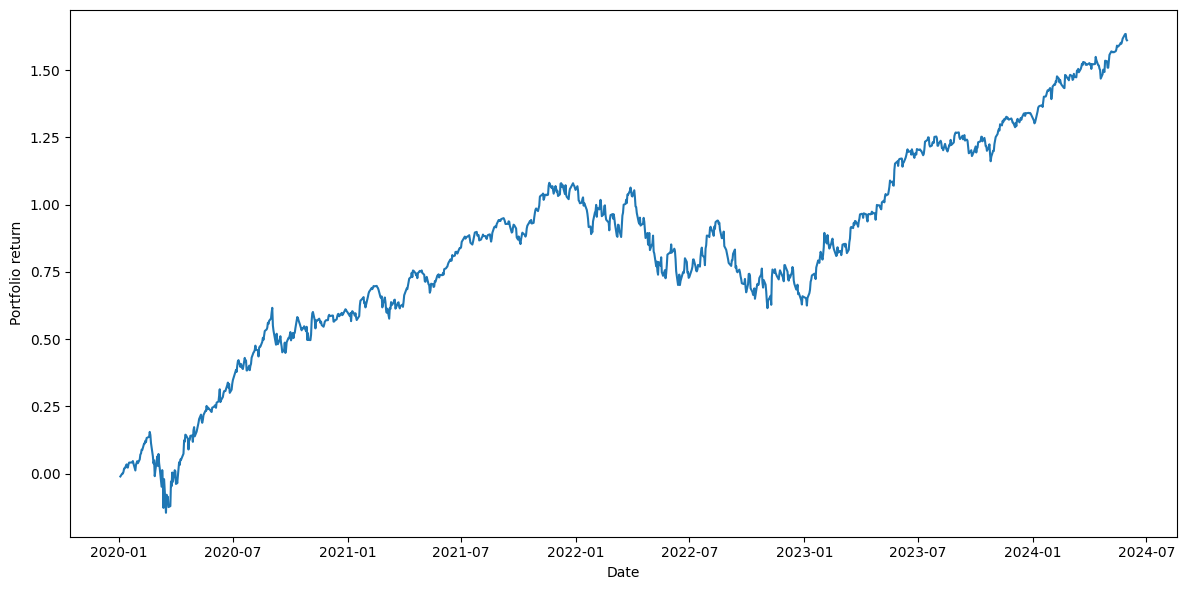

In [4]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label = 'Cumulative Portfolio Return')
plt.xlabel('Date')
plt.ylabel('Portfolio return')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import t
df, loc, scale = t.fit(portfolio_returns)
loc-mean, scale-std_dev

(np.float64(0.0004312150690937459), np.float64(-0.005043323227489642))

In [15]:
param_VaR = t.ppf(0.05, df, loc=loc, scale=scale)
CVaR=portfolio_returns[portfolio_returns <= param_VaR].mean()
print(f"1 day Value at Risk (VaR) at 95% confidence level: {param_VaR:.4f}")
print(f"1 day Conditional Value at Risk (CVaR) at 95% confidence level: {CVaR:.4f}")

1 day Value at Risk (VaR) at 95% confidence level: -0.0296
1 day Conditional Value at Risk (CVaR) at 95% confidence level: -0.0427


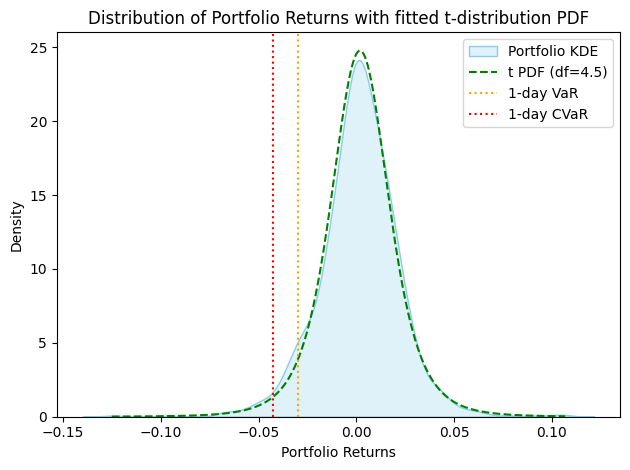

In [20]:
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')
plt.axvline(param_VaR, color='orange', linestyle=':', label='1-day VaR')
plt.axvline(CVaR, color='red', linestyle=':', label='1-day CVaR')

plt.title('Distribution of Portfolio Returns with fitted t-distribution PDF')
plt.xlabel('Portfolio Returns')
plt.legend()
plt.tight_layout()
plt.show()